# Casino HMM: learning (parameter estimation)

We use a simple example of an HMM from known as the "occasionally dishonest casino".
This is from sec 3.2 of the book
"Biological Sequence Analysis: Probabilistic Models of Proteins and Nucleic Acids"
by R. Durbin, S. Eddy, A. Krogh and G. Mitchison (1998).

We sample data from the model, then fit the model to the data, using EM and SGD.


The figure below shows the graphical model, with the parameter nodes explicitly added.


![HMM with parameters](https://github.com/probml/dynamax/blob/main/docs/figures/hmmDgmPlatesY.png?raw=true)


## Setup

In [1]:
try:
    import dynamax
except ModuleNotFoundError:
    print('installing dynamax')
    %pip install -qq git+https://github.com/probml/dynamax.git
    import dynamax

In [2]:
from functools import partial
import jax.numpy as jnp
import jax.random as jr
from jax import vmap
import optax
from graphviz import Digraph
import matplotlib.pyplot as plt
from dynamax.hmm.models import CategoricalHMM

In [3]:
#try:
#    import graphviz
#except ModuleNotFoundError:
#    %pip install graphviz

In [4]:
def hmm_plot_graphviz(trans_mat, obs_mat, states=[], observations=[]):
    """
    Visualizes HMM transition matrix and observation matrix using graphhiz.
    Parameters
    ----------
    trans_mat, obs_mat, init_dist: arrays
    states: List(num_hidden)
        Names of hidden states
    observations: List(num_obs)
        Names of observable events
    Returns
    -------
    dot object, that can be displayed in colab
    """

    n_states, _, n_obs = obs_mat.shape

    dot = Digraph(comment="HMM")
    if not states:
        states = [f"State {i + 1}" for i in range(n_states)]
    if not observations:
        observations = [f"Obs {i + 1}" for i in range(n_obs)]

    # Creates hidden state nodes
    for i, name in enumerate(states):
        table = [f'<TR><TD>{observations[j]}</TD><TD>{"%.2f" % prob}</TD></TR>' for j, prob in enumerate(obs_mat[i,0])]
        label = f"""<<TABLE><TR><TD BGCOLOR="lightblue" COLSPAN="2">{name}</TD></TR>{''.join(table)}</TABLE>>"""
        dot.node(f"s{i}", label=label)

    # Writes transition probabilities
    for i in range(n_states):
        for j in range(n_states):
            dot.edge(f"s{i}", f"s{j}", label=str("%.2f" % trans_mat[i, j]))
    dot.attr(rankdir="LR")
    # dot.render(file_name, view=True)
    return dot

## Sample data from true model

In [5]:
num_states = 2
num_emissions = 1
num_classes = 6
hmm = CategoricalHMM(num_states, num_emissions, num_classes)

params = dict(
    initial=dict(probs=jnp.array([1, 1]) / 2),
    transitions=dict(transition_matrix=jnp.array([[0.95, 0.05], [0.10, 0.90]])),
    emissions=dict(probs=jnp.array(
        [
            [1 / 6, 1 / 6, 1 / 6, 1 / 6, 1 / 6, 1 / 6],  # fair die
            [1 / 10, 1 / 10, 1 / 10, 1 / 10, 1 / 10, 5 / 10],  # loaded die
        ]
    ).reshape(num_states, num_emissions, num_classes))
)

In [6]:

num_batches = 5
num_timesteps = 5000
hmm = CategoricalHMM(num_states, num_emissions, num_classes)

batch_states, batch_emissions = \
    vmap(partial(hmm.sample, params, num_timesteps=num_timesteps))(
        jr.split(jr.PRNGKey(42), num_batches))

print(batch_states.shape) 
print(batch_emissions.shape)
print(batch_emissions.size)

(5, 5000)
(5, 5000, 1)
25000


In [7]:
def extract_params(params):
    A = params['transitions']['transition_matrix']
    B = params['emissions']['probs'] # (nstates, 1, noutputs)
    pi = params['initial']['probs']
    return pi, A, B[:, 0, :]

def print_floats(probs):
    str = ['{:.3f},'.format(p) for p in probs]
    print(str)

def print_params(params):
    pi, A, B = extract_params(params)
    print('initial dist: ');
    print_floats(pi)
    print('transition matrix')
    nstates = len(pi)
    for k in range(nstates):
        print_floats(A[k,:])
    print('emission matrix')
    for k in range(nstates):
        print_floats(B[k,:])

print_params(params)


initial dist: 
['0.500,', '0.500,']
transition matrix
['0.950,', '0.050,']
['0.100,', '0.900,']
emission matrix
['0.167,', '0.167,', '0.167,', '0.167,', '0.167,', '0.167,']
['0.100,', '0.100,', '0.100,', '0.100,', '0.100,', '0.500,']


In [8]:
#dotfile = hmm_plot_graphviz(params["transitions"]["transition_matrix"], params["emissions"]["probs"])
#dotfile.render("hmm-casino-true-dot")
#dotfile

## Learning

In [9]:
num_epochs = 400
learning_rate = 1e-2
momentum = 0.95
optimizer = optax.sgd(learning_rate=learning_rate, momentum=momentum)
shuffle = True

### Full-Batch Gradient Descent

In [10]:
key = jr.PRNGKey(3)
fbgd_params, fbgd_param_props = hmm.initialize(key)
fbgd_params, losses_fbgd = hmm.fit_sgd(fbgd_params, 
                                       fbgd_param_props, 
                                       batch_emissions, 
                                       optimizer=optimizer, 
                                       batch_size=num_batches, 
                                       num_epochs=num_epochs, 
                                       shuffle=shuffle, 
                                       key=key)

In [11]:
print_params(fbgd_params)

initial dist: 
['0.035,', '0.971,']
transition matrix
['0.036,', '0.964,']
['0.430,', '0.570,']
emission matrix
['0.137,', '0.238,', '0.212,', '0.056,', '0.261,', '0.096,']
['0.151,', '0.105,', '0.112,', '0.179,', '0.085,', '0.369,']


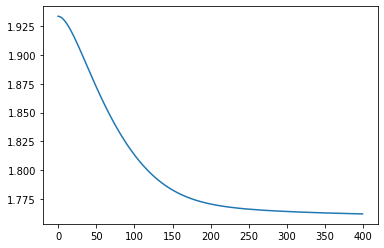

In [12]:
fig, ax = plt.subplots()
ax.plot(losses_fbgd)

### Mini-Batch Gradient Descent

In [13]:
key = jr.PRNGKey(3)
mbgd_params, mbgd_param_props = hmm.initialize(key)
mbgd_params, losses_mbgd = hmm.fit_sgd(mbgd_params, 
                                       mbgd_param_props, 
                                       batch_emissions, 
                                       optimizer=optimizer, 
                                       batch_size=2, 
                                       num_epochs=num_epochs, 
                                       shuffle=shuffle, 
                                       key=key)

In [14]:
print_params(mbgd_params)

initial dist: 
['0.035,', '0.983,']
transition matrix
['0.038,', '0.962,']
['0.314,', '0.686,']
emission matrix
['0.142,', '0.234,', '0.202,', '0.067,', '0.252,', '0.103,']
['0.150,', '0.120,', '0.127,', '0.169,', '0.106,', '0.329,']


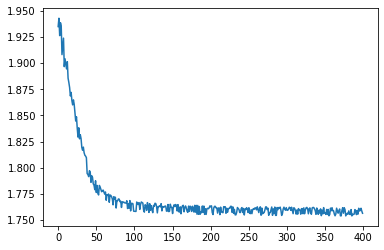

In [15]:
fig, ax = plt.subplots()
ax.plot(losses_mbgd)


### Expectation-Maximization

In [16]:
key = jr.PRNGKey(3)
em_params, em_param_props = hmm.initialize(key)

print('parameters before learning')
print_params(em_params)

em_params, log_liks = hmm.fit_em(em_params, 
                                 em_param_props, 
                                 batch_emissions.reshape(-1, 1), 
                                 num_iters=num_epochs)
losses_em = -log_liks / batch_emissions.size # divide by (num sequences * num time steps), so scale is comparable to sgd

print('parameters after learning')
print_params(em_params)

parameters before learning
initial dist: 
['0.035,', '0.965,']
transition matrix
['0.032,', '0.968,']
['0.430,', '0.570,']
emission matrix
['0.112,', '0.241,', '0.038,', '0.039,', '0.499,', '0.070,']
['0.145,', '0.085,', '0.017,', '0.191,', '0.082,', '0.479,']


100%|██████████| 400/400 [00:02<00:00, 180.49it/s]


parameters after learning
initial dist: 
['0.362,', '0.638,']
transition matrix
['0.073,', '0.927,']
['0.358,', '0.642,']
emission matrix
['0.024,', '0.212,', '0.103,', '0.177,', '0.221,', '0.264,']
['0.196,', '0.124,', '0.162,', '0.131,', '0.112,', '0.275,']


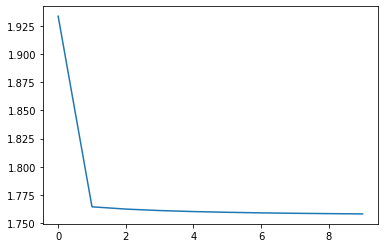

In [17]:
fig, ax = plt.subplots()
ax.plot(losses_em[:10])